# Prediction using the tweet (text)

Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

import string
import nltk
from nltk.corpus import stopwords

from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split 
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
import plotly 
import plotly.graph_objects as go
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()


In [2]:
df = pd.read_csv('train1.csv')
df.head()

,Tweet,Type,Unnamed: 2
0,Good Morning Love @LeeBrown_V,Quality,NaN
1,'@realDonaldTrump @USNavy RIP TO HEROES',Spam,NaN
2,Haven't been following the news but I understa...,Quality,NaN
3,pic.twitter.com/dy9q4ftLhZ What to do with pap...,Quality,NaN
4,#DidYouKnow ► Mahatma Gandhi made a brief visi...,Quality,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14899 entries, 0 to 14898
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Tweet       14899 non-null  object
 1   Type        14899 non-null  object
 2   Unnamed: 2  2 non-null      object
dtypes: object(3)
memory usage: 349.3+ KB


In [4]:
df = df.drop("Unnamed: 2",axis = 1)

In [5]:
df.describe()

,Tweet,Type
count,14899,14899
unique,14682,3
top,[HAPPY BIRTHDAY TAEYANG]\noriginally posted by...,Quality
freq,12,7454


In [6]:
df.groupby('Type').describe().T

Type                                                    Quality  \
Tweet count                                                7454   
      unique                                               7256   
      top     [HAPPY BIRTHDAY TAEYANG]\noriginally posted by...   
      freq                                                   12   

Type                                               South Dakota  \
Tweet count                                                   2   
      unique                                                  2   
      top     #Virgos are usually very helpful around the ho...   
      freq                                                    1   

Type                                                       Spam  
Tweet count                                                7443  
      unique                                               7424  
      top     Alys Fowler: vegetable plants for a new garden...  
      freq                                                    2

In [7]:
df = df[df.Type != "South Dakota"]

In [8]:
df.groupby('Type').describe().T

Type                                                    Quality  \
Tweet count                                                7454   
      unique                                               7256   
      top     [HAPPY BIRTHDAY TAEYANG]\noriginally posted by...   
      freq                                                   12   

Type                                                       Spam  
Tweet count                                                7443  
      unique                                               7424  
      top     Alys Fowler: vegetable plants for a new garden...  
      freq                                                    2

In [9]:
df['length'] = df['Tweet'].apply(len)
df.head()

,Tweet,Type,length
0,Good Morning Love @LeeBrown_V,Quality,30
1,'@realDonaldTrump @USNavy RIP TO HEROES',Spam,40
2,Haven't been following the news but I understa...,Quality,82
3,pic.twitter.com/dy9q4ftLhZ What to do with pap...,Quality,149
4,#DidYouKnow ► Mahatma Gandhi made a brief visi...,Quality,108


In [10]:
# convert categorical v1 to numerical with new column
df['v1_nm'] = df.Type.map({'Quality':0, 'Spam':1})
df.head()

,Tweet,Type,length,v1_nm
0,Good Morning Love @LeeBrown_V,Quality,30,0
1,'@realDonaldTrump @USNavy RIP TO HEROES',Spam,40,1
2,Haven't been following the news but I understa...,Quality,82,0
3,pic.twitter.com/dy9q4ftLhZ What to do with pap...,Quality,149,0
4,#DidYouKnow ► Mahatma Gandhi made a brief visi...,Quality,108,0


In [11]:
df['Type'].value_counts()

Quality    7454
Spam       7443
Name: Type, dtype: int64

Text(0.5, 0, 'Message length')

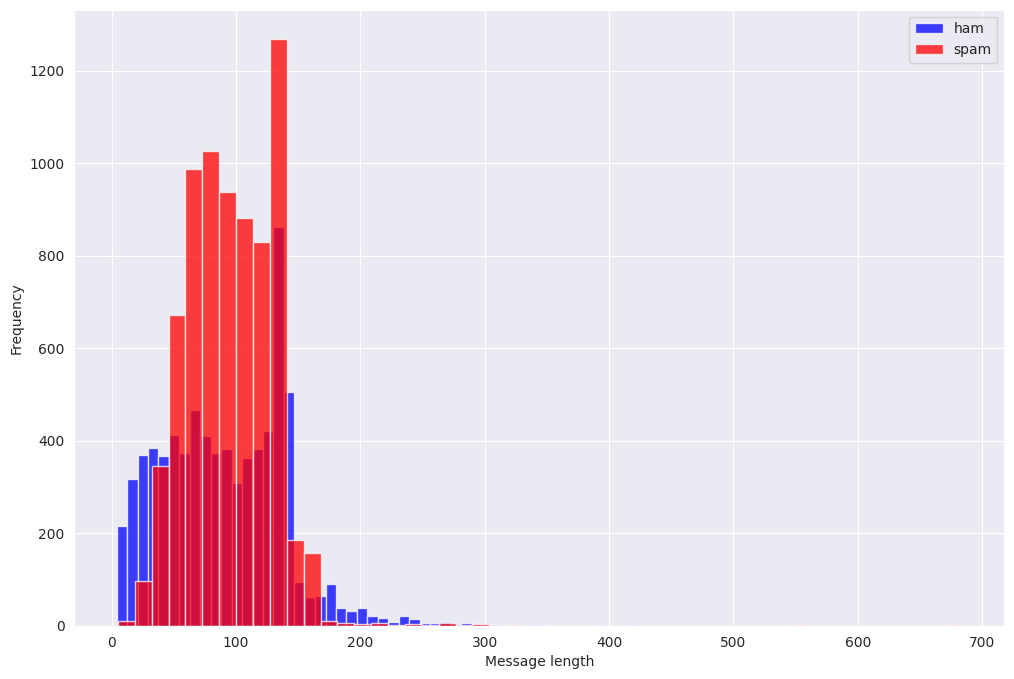

In [12]:
plt.figure(figsize=(12,8))
df[df['Type']=='Quality'].length.plot(bins = 50, kind= 'hist', color='blue', label='ham', alpha=0.75)
df[df['Type']=='Spam'].length.plot(bins=50, kind= 'hist', color='red', label = 'spam', alpha=0.75)
plt.legend()
plt.xlabel('Message length')

In [13]:
# describe the ham for some numerical insights
df[df['Type']=='Quality'].describe()

,length,v1_nm
count,7454.000000,7454.0
mean,90.279850,0.0
std,49.527969,0.0
min,4.000000,0.0
25%,50.000000,0.0
50%,88.000000,0.0
75%,130.000000,0.0
max,424.000000,0.0


In [14]:
#describe the both numerical columns
df.describe()

,length,v1_nm
count,14897.000000,14897.000000
mean,93.255689,0.499631
std,43.028087,0.500017
min,4.000000,0.000000
25%,62.000000,0.000000
50%,93.000000,0.000000
75%,127.000000,1.000000
max,684.000000,1.000000


In [15]:
# see in describe we have 684 word message, let's look at it
df[df['length']==684].Tweet.iloc[0]

"'@Hakimyasin @ThisGuysTaint @gazafreee @PalestineFamily @Torterra21 @helen_tiger @zugly747 @FR33_W0RLD @RKazbaar @Paulfowler1 @ralvarezdj @Raz581 @Springbaby777 @_moobs_ @bdsjacquot @coinabs @LovesTheFab4 @RokedvMagen @lisabarrett23 @Andysolomono @mohamedAbouswel @SpinMeister_UK @harmlesstree2 @Free4Hungry @LollllllaJR @MLKstudios @iamsideeque @ANINDAUK @joe_n1nety @TanyaKasim @AnwarPrinceP @MrNegroMilitant @AlCaselli @khussh_ @gallinini1 @loveangel412 @Ramdog1980 @teddy_cat1 @ghalianno @rk70534 @Laizesfaire @purplhaze42 @AngelWarrior512 Palestine would be self-sufficient on natural gas reserves so Israel perpetuates war to cover theft #BDS #Apartheid https://t.co/UzJ3WD3oft'"

Pre processing

In [16]:
import string 
from nltk.corpus import stopwords

def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    STOPWORDS = stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure']
    
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]
    
    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return ' '.join([word for word in nopunc.split() if word.lower() not in STOPWORDS])

In [17]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [18]:
df['clean_msg'] = df.Tweet.apply(text_process)

In [19]:
df.head()

,Tweet,Type,length,v1_nm,clean_msg
0,Good Morning Love @LeeBrown_V,Quality,30,0,Good Morning Love LeeBrownV
1,'@realDonaldTrump @USNavy RIP TO HEROES',Spam,40,1,realDonaldTrump USNavy RIP HEROES
2,Haven't been following the news but I understa...,Quality,82,0,Havent following news understand EFF dumbest t...
3,pic.twitter.com/dy9q4ftLhZ What to do with pap...,Quality,149,0,pictwittercomdy9q4ftLhZ paper scissors glue ht...
4,#DidYouKnow ► Mahatma Gandhi made a brief visi...,Quality,108,0,DidYouKnow ► Mahatma Gandhi made brief visit l...


In [20]:
from collections import Counter

words = df[df['Type']=='Quality'].clean_msg.apply(lambda x: [word.lower() for word in x.split()])
ham_words = Counter()

for msg in words:
    ham_words.update(msg)
    
print(ham_words.most_common(50))

[('…', 1130), ('like', 271), ('new', 240), ('get', 232), ('love', 224), ('know', 186), ('one', 183), ('day', 180), ('happy', 173), ('good', 172), ('time', 152), ('people', 148), ('today', 147), ('via', 147), ('go', 137), ('need', 127), ('us', 127), ('cant', 124), ('got', 121), ('want', 117), ('thank', 116), ('think', 116), ('make', 114), ('please', 113), ('life', 111), ('see', 111), ('birthday', 108), ('back', 102), ('thanks', 97), ('best', 94), ('really', 94), ('great', 93), ('last', 93), ('would', 92), ('still', 91), ('lol', 90), ('never', 89), ('much', 89), ('video', 86), ('first', 85), ('may', 85), ('going', 84), ('right', 83), ('take', 82), ('even', 82), ('work', 82), ('thats', 82), ('1', 81), ('come', 80), ('always', 80)]


In [21]:
words = df[df.Type=='Spam'].clean_msg.apply(lambda x: [word.lower() for word in x.split()])
spam_words = Counter()

for msg in words:
    spam_words.update(msg)
    
print(spam_words.most_common(50))

[('news', 574), ('trump', 507), ('rt', 332), ('us', 252), ('new', 252), ('police', 217), ('sports', 205), ('man', 203), ('people', 183), ('politics', 160), ('world', 156), ('one', 154), ('breaking', 153), ('obama', 153), ('like', 152), ('amp', 147), ('get', 140), ('video', 136), ('black', 134), ('white', 127), ('local', 118), ('says', 117), ('time', 113), ('hillary', 111), ('president', 108), ('day', 103), ('america', 102), ('via', 101), ('trumps', 96), ('love', 96), ('state', 94), ('woman', 94), ('go', 93), ('make', 92), ('health', 92), ('good', 90), ('first', 89), ('watch', 89), ('media', 87), ('know', 87), ('want', 86), ('clinton', 84), ('house', 84), ('killed', 84), ('never', 82), ('back', 81), ('see', 81), ('cant', 80), ('would', 79), ('need', 79)]


Vectorization

In [22]:
X = df.clean_msg
y = df.v1_nm
print(X.shape)
print(y.shape)

(14897,)
(14897,)


In [23]:
# split X and y into training and testing sets 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(11172,)
(3725,)
(11172,)
(3725,)


In [24]:
from sklearn.feature_extraction.text import CountVectorizer

# instantiate the vectorizer
vect = CountVectorizer()
vect.fit(X_train)

CountVectorizer()

In [25]:
# learn training data vocabulary, then use it to create a document-term matrix
X_train_dtm = vect.transform(X_train)

# equivalently: combine fit and transform into a single step
X_train_dtm = vect.fit_transform(X_train)

# examine the document-term matrix
X_train_dtm

<11172x30694 sparse matrix of type '<class 'numpy.int64'>'
	with 90101 stored elements in Compressed Sparse Row format>

In [26]:
# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test)
X_test_dtm

<3725x30694 sparse matrix of type '<class 'numpy.int64'>'
	with 22527 stored elements in Compressed Sparse Row format>

In [27]:
#transform a count matrix to a normalized tf or tf-idf representation
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(X_train_dtm)
tfidf_transformer.transform(X_train_dtm)

<11172x30694 sparse matrix of type '<class 'numpy.float64'>'
	with 90101 stored elements in Compressed Sparse Row format>

Test based Multinomial Naive Bayers

In [28]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [29]:
# train the model using X_train_dtm (timing it with an IPython "magic command")
%time nb.fit(X_train_dtm, y_train)

CPU times: user 5.79 ms, sys: 0 ns, total: 5.79 ms
Wall time: 5.81 ms


MultinomialNB()

In [30]:
# make class predictions for X_test_dtm
y_pred_class = nb.predict(X_test_dtm)
y_pred_class

array([0, 0, 0, ..., 0, 1, 1])

In [31]:
# calculate accuracy of class predictions
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_class)

0.7879194630872484

In [32]:
# print the confusion matrix
metrics.confusion_matrix(y_test, y_pred_class)
print(metrics.classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.78      0.80      0.79      1867
           1       0.79      0.78      0.79      1858

    accuracy                           0.79      3725
   macro avg       0.79      0.79      0.79      3725
weighted avg       0.79      0.79      0.79      3725



In [33]:
df2=pd.read_csv('ProjectK.csv')
df2.head()

,Unnamed: 0,tweets
0,0,RT @rebelismm999: Day1 500cr+ 🥵💥🔥\n\n#Prabhas'...
1,1,RT @Lord_Prabhas: Mass 🔥🔥🔥 #ProjectK #Prabhas ...
2,2,RT @IMDb_in: Just watched this video from #Pro...
3,3,RT @greatandhranews: We usually see this kind ...
4,4,RT @SaiKiranTweetss: It's 1M for skratch Ep-1 ...


In [34]:
realtest = vect.transform(df2['tweets'])
y_pred_class = nb.predict(realtest)
y_pred_class

array([1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0])

Logistic Regression

In [45]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='liblinear')

In [46]:
# train the model using X_train_dtm
%time logreg.fit(X_train_dtm, y_train)

CPU times: user 65.2 ms, sys: 48.8 ms, total: 114 ms
Wall time: 68.5 ms


LogisticRegression(solver='liblinear')

In [47]:
# make class predictions for X_test_dtm
y_pred_class = logreg.predict(X_test_dtm)
y_pred_class

array([0, 0, 0, ..., 0, 1, 1])

In [48]:
# calculate accuracy
metrics.accuracy_score(y_test, y_pred_class)

0.7820134228187919

In [49]:
print(metrics.classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.74      0.86      0.80      1867
           1       0.84      0.70      0.76      1858

    accuracy                           0.78      3725
   macro avg       0.79      0.78      0.78      3725
weighted avg       0.79      0.78      0.78      3725



In [50]:
# # calculate predicted probabilities for X_test_dtm (well calibrated)
y_pred_prob = logreg.predict_proba(X_test_dtm)[:, 1]
y_pred_prob

array([0.31197112, 0.07961286, 0.11020342, ..., 0.32708373, 0.69528834,
       0.59967248])

In [51]:
# calculate AUC
metrics.roc_auc_score(y_test, y_pred_prob)

0.8467575757750471

RandomForest

In [52]:
from sklearn.ensemble import RandomForestClassifier

spam_classifier = RandomForestClassifier(n_estimators=200, random_state=0)
spam_classifier.fit(X_train_dtm, y_train)
# Use the classifier for predictions
predictions = spam_classifier.predict(X_test_dtm)

print(metrics.confusion_matrix(y_test, predictions))
print(metrics.accuracy_score(y_test, predictions))
print(metrics.classification_report(y_test, predictions))

[[1706  161]
 [ 678 1180]]
0.7747651006711409
              precision    recall  f1-score   support

           0       0.72      0.91      0.80      1867
           1       0.88      0.64      0.74      1858

    accuracy                           0.77      3725
   macro avg       0.80      0.77      0.77      3725
weighted avg       0.80      0.77      0.77      3725



Support vector machines

In [53]:
#Import svm model
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train_dtm, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test_dtm)

print(metrics.accuracy_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

0.7734228187919463
              precision    recall  f1-score   support

           0       0.74      0.85      0.79      1867
           1       0.82      0.69      0.75      1858

    accuracy                           0.77      3725
   macro avg       0.78      0.77      0.77      3725
weighted avg       0.78      0.77      0.77      3725



Decision Tree

In [54]:
from sklearn.tree import DecisionTreeClassifier
spam_classifier = DecisionTreeClassifier()
spam_classifier.fit(X_train_dtm, y_train)
# Use the classifier for predictions
predictions = spam_classifier.predict(X_test_dtm)

print(metrics.confusion_matrix(y_test, predictions))
print(metrics.accuracy_score(y_test, predictions))
print(metrics.classification_report(y_test, predictions))

[[1478  389]
 [ 535 1323]]
0.7519463087248323
              precision    recall  f1-score   support

           0       0.73      0.79      0.76      1867
           1       0.77      0.71      0.74      1858

    accuracy                           0.75      3725
   macro avg       0.75      0.75      0.75      3725
weighted avg       0.75      0.75      0.75      3725



Crawler

In [1]:
import re
import csv
from getpass import getpass
from time import sleep
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import NoSuchElementException
from msedge.selenium_tools import Edge, EdgeOptions

def get_tweet_data(card):
    """Extract data from tweet card"""
    username = card.find_element("xpath",'.//span').text
    try:
        handle = card.find_element("xpath",'.//span[contains(text(), "@")]').text
    except NoSuchElementException:
        return
    
    try:
        postdate = card.find_element("xpath",'.//time').get_attribute('datetime')
    except NoSuchElementException:
        return
    
    comment = card.find_element("xpath",'.//div[2]/div[2]/div[1]').text
    responding = card.find_element("xpath",'.//div[2]/div[2]/div[2]').text
    text = comment + responding
    reply_cnt = card.find_element("xpath",'.//div[@data-testid="reply"]').text
    retweet_cnt = card.find_element("xpath",'.//div[@data-testid="retweet"]').text
    like_cnt = card.find_element("xpath",'.//div[@data-testid="like"]').text
    
    # get a string of all emojis contained in the tweet
    """Emojis are stored as images... so I convert the filename, which is stored as unicode, into 
    the emoji character."""
    emoji_tags = card.find_elements("xpath",'.//img[contains(@src, "emoji")]')
    emoji_list = []
    for tag in emoji_tags:
        filename = tag.get_attribute('src')
        try:
            emoji = chr(int(re.search(r'svg\/([a-z0-9]+)\.svg', filename).group(1), base=16))
        except AttributeError:
            continue
        if emoji:
            emoji_list.append(emoji)
    emojis = ' '.join(emoji_list)
    
    tweet = (username, handle, postdate, text, emojis, reply_cnt, retweet_cnt, like_cnt)
    return tweet    

In [2]:
# application variables
user = input('username: ')
my_password = getpass('Password: ')
search_term = input('search term: ')

# create instance of web driver
options = EdgeOptions()
options.use_chromium = True
driver = Edge(options=options)

# navigate to login screen
driver.get('https://www.twitter.com/login')
driver.maximize_window()
sleep(5)
username = driver.find_element("xpath",'//input[@name="text"]')
username.send_keys(user)
username.send_keys(Keys.RETURN)
sleep(3)

password = driver.find_element('xpath','//input[@name="password"]')
password.send_keys(my_password)
password.send_keys(Keys.RETURN)
sleep(3)

# find search input and search for term
search_input = driver.find_element('xpath','//input[@aria-label="Search query"]')
search_input.send_keys(search_term)
search_input.send_keys(Keys.RETURN)
sleep(1)

# navigate to historical 'latest' tab
driver.find_element("link text",'Latest').click()

username: Dathu55483800
Password: ········
search term: #ProjectK


C:\Users\kldat\AppData\Local\Temp\ipykernel_9340\2993799708.py:9: DeprecationWarning: Selenium Tools for Microsoft Edge is deprecated. Please upgrade to Selenium 4 which has built-in support for Microsoft Edge (Chromium): https://docs.microsoft.com/en-us/microsoft-edge/webdriver-chromium/#upgrading-from-selenium-3
  driver = Edge(options=options)


In [3]:
# get all tweets on the page
data = []
twitter_tweet_ = []
tweet_ids = set()
last_position = driver.execute_script("return window.pageYOffset;")
scrolling = True

while scrolling:
    page_cards = driver.find_elements('xpath', '//article[@data-testid="tweet"]')
    for card in page_cards[-15:]:
        tweet = get_tweet_data(card)
        if tweet:
            tweet_id = ''.join(tweet)
            if tweet_id not in tweet_ids:
                tweet_ids.add(tweet_id)
                data.append(tweet)
                twitter_tweet_.append(tweet[3])
            
    scroll_attempt = 0
    while True:
        # check scroll position
        driver.execute_script('window.scrollTo(0, document.body.scrollHeight);')
        sleep(2)
        curr_position = driver.execute_script("return window.pageYOffset;")
        if last_position == curr_position:
            scroll_attempt += 1
            
            # end of scroll region
            if scroll_attempt >= 3:
                scrolling = False
                break
            else:
                sleep(2) # attempt another scroll
        else:
            last_position = curr_position
            break

# close the web driver
driver.close()

In [4]:
len(data)

1036

In [5]:
with open('ProjectK.csv', 'w', newline='', encoding='utf-8') as f:
    header = ['UserName', 'Handle', 'Timestamp', 'Text', 'Emojis', 'Comments', 'Likes', 'Retweets']
    writer = csv.writer(f)
    writer.writerow(header)
    writer.writerows(data)

In [7]:
import pandas as pd
header = ['UserName', 'Handle', 'Timestamp', 'Text', 'Emojis', 'Comments', 'Likes', 'Retweets']
df = pd.DataFrame(data,columns= header)
df.head()

,UserName,Handle,Timestamp,Text,Emojis,Comments,Likes,Retweets
0,STRANGER from #Project-K,@AB_Animator,2023-04-10T15:39:04.000Z,STRANGER from #Project-K\n@AB_Animator\n·\n8mR...,💓,,,
1,TV9 Kannada,@tv9kannada,2023-04-10T15:38:34.000Z,TV9 Kannada\n@tv9kannada\n·\n9m‘ವೈಜಯಂತಿ ಮೂವೀಸ್...,,,,1
2,Rahulˢᵃˡᵃᵃʳ,@rahulprabha777,2023-04-10T15:37:41.000Z,Rahulˢᵃˡᵃᵃʳ\n@rahulprabha777\n·\n10mProject k\...,👌,,,1
3,Sᴜʙʜᴀsʜ_Dᴀʀʟɪɴɢ,@vanam_subhash,2023-04-10T15:28:25.000Z,Sᴜʙʜᴀsʜ_Dᴀʀʟɪɴɢ\n@vanam_subhash\n·\n19mAnna nt...,💥 ❤ 🔥 ✊,,1,3
4,NEWS3PEOPLE,@news3people,2023-04-10T15:28:09.000Z,NEWS3PEOPLE\n@news3people\n·\n19mSankranthi 20...,👉 👉 👉 👉 👉,,,1


In [8]:
twitter_tweet = pd.array(twitter_tweet_)
df['Text'] = twitter_tweet

In [9]:
df.head() # gives the updated dataset

,UserName,Handle,Timestamp,Text,Emojis,Comments,Likes,Retweets
0,STRANGER from #Project-K,@AB_Animator,2023-04-10T15:39:04.000Z,STRANGER from #Project-K @AB_Animator · 8mRepl...,💓,,,
1,TV9 Kannada,@tv9kannada,2023-04-10T15:38:34.000Z,TV9 Kannada @tv9kannada · 9m‘ವೈಜಯಂತಿ ಮೂವೀಸ್’ ಮ...,,,,1
2,Rahulˢᵃˡᵃᵃʳ,@rahulprabha777,2023-04-10T15:37:41.000Z,Rahulˢᵃˡᵃᵃʳ @rahulprabha777 · 10mProject k Ep...,👌,,,1
3,Sᴜʙʜᴀsʜ_Dᴀʀʟɪɴɢ,@vanam_subhash,2023-04-10T15:28:25.000Z,Sᴜʙʜᴀsʜ_Dᴀʀʟɪɴɢ @vanam_subhash · 19mAnna ntry ...,💥 ❤ 🔥 ✊,,1,3
4,NEWS3PEOPLE,@news3people,2023-04-10T15:28:09.000Z,NEWS3PEOPLE @news3people · 19mSankranthi 2024 ...,👉 👉 👉 👉 👉,,,1


In [10]:
df.tail()

,UserName,Handle,Timestamp,Text,Emojis,Comments,Likes,Retweets
1031,Rahul,@Rahul__12,2023-03-30T17:11:46.000Z,Rahul @Rahul__12 · Mar 30Waiting for your musi...,,,,1
1032,Ganeshen,@Ganeshen5,2023-03-30T17:11:04.000Z,Ganeshen @Ganeshen5 · Mar 30Expecting not only...,🌶,,4,13
1033,Kapil,@kapil_9966,2023-03-30T15:33:39.000Z,Kapil @kapil_9966 · Mar 30#projectK bokka vast...,,2,,4
1034,వాయుపుత్రుడు,@Vaayuputrudu,2023-03-30T15:28:47.000Z,వాయుపుత్రుడు @Vaayuputrudu · Mar 30#Prabhas #A...,🌪 🙏 🚩 ❤ 💞 🚩 🙏 ❤ 🌊,,2,5
1035,PRABHAS RAJU,@KManika55490427,2023-03-30T15:27:22.000Z,PRABHAS RAJU @KManika55490427 · Mar 30Plz help...,🏹,,3,2


In [11]:
df.to_csv('mydata.csv', index=False)

In [12]:
data

[('STRANGER from #Project-K',
  '@AB_Animator',
  '2023-04-10T15:39:04.000Z',
  'STRANGER from #Project-K\n@AB_Animator\n·\n8mReplying to \n@taran_adarsh\n @BabaSiddique\n and 6 others',
  '💓',
  '',
  '',
  ''),
 ('TV9 Kannada',
  '@tv9kannada',
  '2023-04-10T15:38:34.000Z',
  'TV9 Kannada\n@tv9kannada\n·\n9m‘ವೈಜಯಂತಿ ಮೂವೀಸ್’ ಮೂಲಕ ‘ಪ್ರಾಜೆಕ್ಟ್ ಕೆ’ ಸಿನಿಮಾ ಸಿದ್ಧವಾಗುತ್ತಿದೆ. ಈ ಚಿತ್ರಕ್ಕೆ ಬಹುಕೋಟಿ ರೂಪಾಯಿ ಬಂಡವಾಳ ಸುರಿಯಲಾಗಿದೆ.\n\n#Prabhas #DeepikaPadukone #ProjectK\n\nತಾಜಾ ಸುದ್ದಿಗಾಗಿ ಟಿವಿ9 ಕನ್ನಡ ಕಮ್ಯುನಿಟಿ ಸೇರಿ\nhttps://chat.whatsapp.com/HpkzrkGNQ861ejxLCfdk7d…',
  '',
  '',
  '',
  '1'),
 ('Rahulˢᵃˡᵃᵃʳ',
  '@rahulprabha777',
  '2023-04-10T15:37:41.000Z',
  'Rahulˢᵃˡᵃᵃʳ\n@rahulprabha777\n·\n10mProject k\n Ep-2  explanation \n#Prabhas #ProjectK\nhttps://youtu.be/Z1sgt25NIV8',
  '👌',
  '',
  '',
  '1'),
 ('Sᴜʙʜᴀsʜ_Dᴀʀʟɪɴɢ',
  '@vanam_subhash',
  '2023-04-10T15:28:25.000Z',
  'Sᴜʙʜᴀsʜ_Dᴀʀʟɪɴɢ\n@vanam_subhash\n·\n19mAnna ntry into Hollywood cinema \n\n#ProjectK #Prabhas',
  '💥 ❤ 🔥 ✊',
  '',
  '1',
  '

In [13]:
tweet


('PRABHAS RAJU',
 '@KManika55490427',
 '2023-03-30T15:27:22.000Z',
 'PRABHAS RAJU\n@KManika55490427\n·\nMar 30Plz help  #prabhas #AdipurushAagamanam #salaar #projectk #Spirit #SSMB29 #JaiShriRam\n #Ukraine #Kojoforex #TATAIPL #skn',
 '🏹',
 '',
 '3',
 '2')

In [14]:
tweet[3]

'PRABHAS RAJU\n@KManika55490427\n·\nMar 30Plz help  #prabhas #AdipurushAagamanam #salaar #projectk #Spirit #SSMB29 #JaiShriRam\n #Ukraine #Kojoforex #TATAIPL #skn'

In [15]:
df["Text"]

0       STRANGER from #Project-K
@AB_Animator
·
8mRepl...
1       TV9 Kannada
@tv9kannada
·
9m‘ವೈಜಯಂತಿ ಮೂವೀಸ್’ ಮ...
2       Rahulˢᵃˡᵃᵃʳ
@rahulprabha777
·
10mProject k
 Ep...
3       Sᴜʙʜᴀsʜ_Dᴀʀʟɪɴɢ
@vanam_subhash
·
19mAnna ntry ...
4       NEWS3PEOPLE
@news3people
·
19mSankranthi 2024 ...
                              ...                        
1031    Rahul
@Rahul__12
·
Mar 30Waiting for your musi...
1032    Ganeshen
@Ganeshen5
·
Mar 30Expecting not only...
1033    Kapil
@kapil_9966
·
Mar 30#projectK bokka vast...
1034    వాయుపుత్రుడు
@Vaayuputrudu
·
Mar 30#Prabhas #A...
1035    PRABHAS RAJU
@KManika55490427
·
Mar 30Plz help...
Name: Text, Length: 1036, dtype: string

In [16]:
twitter_tweet

<StringArray>
[                                                                                                                                                                                                       'STRANGER from #Project-K\n@AB_Animator\n·\n8mReplying to \n@taran_adarsh\n @BabaSiddique\n and 6 others',
                            'TV9 Kannada\n@tv9kannada\n·\n9m‘ವೈಜಯಂತಿ ಮೂವೀಸ್’ ಮೂಲಕ ‘ಪ್ರಾಜೆಕ್ಟ್ ಕೆ’ ಸಿನಿಮಾ ಸಿದ್ಧವಾಗುತ್ತಿದೆ. ಈ ಚಿತ್ರಕ್ಕೆ ಬಹುಕೋಟಿ ರೂಪಾಯಿ ಬಂಡವಾಳ ಸುರಿಯಲಾಗಿದೆ.\n\n#Prabhas #DeepikaPadukone #ProjectK\n\nತಾಜಾ ಸುದ್ದಿಗಾಗಿ ಟಿವಿ9 ಕನ್ನಡ ಕಮ್ಯುನಿಟಿ ಸೇರಿ\nhttps://chat.whatsapp.com/HpkzrkGNQ861ejxLCfdk7d…',
                                                                                                                                                                                           'Rahulˢᵃˡᵃᵃʳ\n@rahulprabha777\n·\n10mProject k\n Ep-2  explanation \n#Prabhas #ProjectK\nhttps://youtu.be/Z1sgt25NIV8',
                                                                 

In [17]:
import pandas as pd
# Read the CSV file into a DataFrame
MYdata = pd.read_csv('C:/Users/kldat/Downloads/ProjectK.csv')

# Print the DataFrame
MYdata.head()

,UserName,Handle,Timestamp,Text,Emojis,Comments,Likes,Retweets
0,STRANGER from #Project-K,@AB_Animator,2023-04-10T15:39:04.000Z,STRANGER from #Project-K\n@AB_Animator\n·\n8mR...,💓,NaN,NaN,NaN
1,TV9 Kannada,@tv9kannada,2023-04-10T15:38:34.000Z,TV9 Kannada\n@tv9kannada\n·\n9m‘ವೈಜಯಂತಿ ಮೂವೀಸ್...,NaN,NaN,NaN,1
2,Rahulˢᵃˡᵃᵃʳ,@rahulprabha777,2023-04-10T15:37:41.000Z,Rahulˢᵃˡᵃᵃʳ\n@rahulprabha777\n·\n10mProject k\...,👌,NaN,NaN,1
3,Sᴜʙʜᴀsʜ_Dᴀʀʟɪɴɢ,@vanam_subhash,2023-04-10T15:28:25.000Z,Sᴜʙʜᴀsʜ_Dᴀʀʟɪɴɢ\n@vanam_subhash\n·\n19mAnna nt...,💥 ❤ 🔥 ✊,NaN,1,3
4,NEWS3PEOPLE,@news3people,2023-04-10T15:28:09.000Z,NEWS3PEOPLE\n@news3people\n·\n19mSankranthi 20...,👉 👉 👉 👉 👉,NaN,NaN,1


In [18]:
MYdata['Text'] = twitter_tweet
MYdata.head()

,UserName,Handle,Timestamp,Text,Emojis,Comments,Likes,Retweets
0,STRANGER from #Project-K,@AB_Animator,2023-04-10T15:39:04.000Z,STRANGER from #Project-K @AB_Animator · 8mRepl...,💓,NaN,NaN,NaN
1,TV9 Kannada,@tv9kannada,2023-04-10T15:38:34.000Z,TV9 Kannada @tv9kannada · 9m‘ವೈಜಯಂತಿ ಮೂವೀಸ್’ ಮ...,NaN,NaN,NaN,1
2,Rahulˢᵃˡᵃᵃʳ,@rahulprabha777,2023-04-10T15:37:41.000Z,Rahulˢᵃˡᵃᵃʳ @rahulprabha777 · 10mProject k Ep...,👌,NaN,NaN,1
3,Sᴜʙʜᴀsʜ_Dᴀʀʟɪɴɢ,@vanam_subhash,2023-04-10T15:28:25.000Z,Sᴜʙʜᴀsʜ_Dᴀʀʟɪɴɢ @vanam_subhash · 19mAnna ntry ...,💥 ❤ 🔥 ✊,NaN,1,3
4,NEWS3PEOPLE,@news3people,2023-04-10T15:28:09.000Z,NEWS3PEOPLE @news3people · 19mSankranthi 2024 ...,👉 👉 👉 👉 👉,NaN,NaN,1


In [19]:
MYdata['Text'][0]

'STRANGER from #Project-K\n@AB_Animator\n·\n8mReplying to \n@taran_adarsh\n @BabaSiddique\n and 6 others'

In [20]:
MYdata.to_csv('UpdatedData.csv', index=False,encoding='utf-8')